In [1]:
import pandas as pd
import os

In [2]:
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms as T
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
df_train = pd.read_csv('competition_train.csv')
df_val = pd.read_csv('competition_val.csv')
df_test = pd.read_csv('competition_test.csv')

In [4]:
def convert_boxes_string_to_list(boxes_string):
    groups = boxes_string.split(";")
    result = []
    for group in groups:
        nums = group.split()
        # Filtrar valores que no son números
        nums = [int(num) for num in nums if num.isdigit()]
        result.append(nums)
    return result

# Aplica la función a la columna 'BoxesString'
df_test['BoxesString'] = df_test['BoxesString'].apply(convert_boxes_string_to_list)
df_train['BoxesString'] = df_train['BoxesString'].apply(convert_boxes_string_to_list)
df_val['BoxesString'] = df_val['BoxesString'].apply(convert_boxes_string_to_list)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir):
        self.df = df
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = T.ToTensor()(Image.open(img_name).convert("RGB"))/255
        boxes = self.df.iloc[idx, 1]
        num_objs = len(boxes)
        boxes = torch.tensor(boxes, dtype=torch.float32)

        labels = torch.ones((len(boxes),), dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target

    def print_image(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        draw = ImageDraw.Draw(image)
        boxes = self.df.iloc[idx, 1]
        for box in boxes:
            draw.rectangle(box, outline="red", width=4)
        plt.imshow(image)
        plt.show()

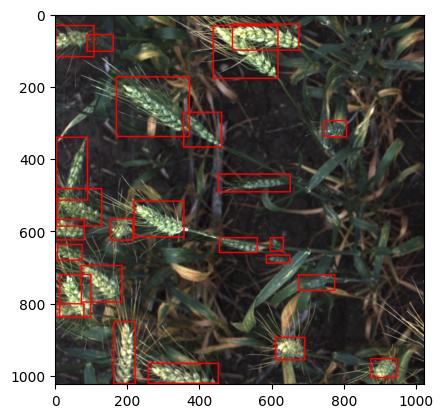

In [6]:
dataset_train = ImageDataset(df_train, 'images')
dataset_val = ImageDataset(df_val, 'images')
dataset_test = ImageDataset(df_test, 'images')

dataset_val.print_image(0)

In [7]:
model = fasterrcnn_resnet50_fpn(progress=True, pretrained_backbone=True, num_classes=2, box_detections_per_img=200)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

data_loader_train = DataLoader(dataset_train, batch_size=8, collate_fn=collate_fn, shuffle=True)

c:\Users\pepbo\miniconda3\envs\cragenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\pepbo\miniconda3\envs\cragenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
class EarlyStopping:
    def __init__(self, patience):
        self.best = 10
        self.count = 0
        self.patience = patience

    def earlyStopping(self, num):
        if num <= self.best:
            self.best = num
            self.count = 0
        else:
            self.count += 1
        if self.count >= self.patience:
            return self.best
        return None

In [10]:
model.train()
early_stopping = EarlyStopping(3)

losses_dict = {'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': [], 'total_loss': []}
stop_training = False

for epoch in tqdm(range(10), desc='epochs', colour='green'):
    if stop_training: 
        break
    
    for images, targets in tqdm(data_loader_train, desc='dataloader', colour='blue'):
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        
        loss_dict = model(images, targets)
        losses_dict['loss_classifier'].append(loss_dict['loss_classifier'].item())
        losses_dict['loss_box_reg'].append(loss_dict['loss_box_reg'].item())
        losses_dict['loss_objectness'].append(loss_dict['loss_objectness'].item())
        losses_dict['loss_rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].item())
        losses = sum(loss for loss in loss_dict.values())
        losses_dict['total_loss'].append(losses.item())
        
        print('Loss_classifier:', loss_dict['loss_classifier'].item())
        print('Loss_box_reg:', loss_dict['loss_box_reg'].item())
        print('Loss_objectness:', loss_dict['loss_objectness'].item())
        print('Loss_rpn_box_reg:', loss_dict['loss_rpn_box_reg'].item())
        print('Total_loss:', losses.item())
        
        for loss in losses_dict['total_loss']:
            best = early_stopping.earlyStopping(loss)
            if best is not None:
                stop_training = True 
                break
        if best is None:  
            best = early_stopping.best
        print(f"Best loss: {best}")
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}, Loss_Classifier: {loss_dict['loss_classifier']}, Loss_Box_Reg: {loss_dict['loss_box_reg']}, Loss_Objectness: {loss_dict['loss_objectness']}, Loss_RPN_Box_Reg: {loss_dict['loss_rpn_box_reg']}, Total_Loss: {loss_dict['total_loss']}")

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Loss_classifier: 0.7022988200187683
Loss_box_reg: 0.11930419504642487
Loss_objectness: 0.6948351263999939
Loss_rpn_box_reg: 0.18990923464298248
Total_loss: 1.7063473463058472
Best loss: 1.7063473463058472


Loss_classifier: 7.359728813171387
Loss_box_reg: 1.1205114126205444
Loss_objectness: 0.5870703458786011
Loss_rpn_box_reg: 0.4568535089492798
Total_loss: 9.524164199829102
Best loss: 1.7063473463058472


Loss_classifier: 12.4671630859375
Loss_box_reg: 2.4828574657440186
Loss_objectness: 0.9801710247993469
Loss_rpn_box_reg: 0.96207594871521
Total_loss: 16.89226722717285
Best loss: 1.7063473463058472


In [ ]:
model.eval()

data_loader_val = DataLoader(dataset_val, batch_size=8, collate_fn=collate_fn)

for images, targets in data_loader_val:
    images = list(image.to(device) for image in images)
    outputs = model(images)
    print(outputs)